In [611]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import datetime
import os
import sys

In [600]:
def get_mean(ror:DataFrame):
    return ror.mean(1).dropna().mean()

def get_nw_t_statistics(ror:Series):
    y = ror.dropna().values
    x = np.array([1] * len(ror.dropna()))
    model = sm.OLS(y, x).fit(cov_type='HAC',cov_kwds={'maxlags':int(len(y) ** 0.25)})
    return model.tvalues[0]

def bootstrap(ror:DataFrame):
    r = ror.fillna(0)
    r_bootstrap = DataFrame({i:np.random.choice(r.loc[:, i], size=len(r), replace=True) for i in r.columns}, index=r.index, columns=r.columns)
    return r_bootstrap

def reg(r_y, r_x):
    y = r_y
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':int(len(y) ** 0.25)})
    return results.params, results.tvalues

In [2]:
for i in os.walk('./NHIndex'):
    d = {j:pd.read_csv('./NHIndex/'+j, index_col=0, parse_dates=[0]) for j in i[2]}

In [7]:
CLOSE = DataFrame({i[:-4]:d[i].close for i in d.keys()})
ror = CLOSE / CLOSE.shift() - 1

In [609]:
form = [1, 5, 20, 60, 120, 250]
hold = [1, 5, 20, 60, 120, 250]
ts_mean = DataFrame(index=form, columns=hold)
ts_std = DataFrame(index=form, columns=hold)
ts_t = DataFrame(index=form, columns=hold)
ts_b = {}
ts_p_b = DataFrame(index=form, columns=hold)

cs_mean = DataFrame(index=form, columns=hold)
cs_std = DataFrame(index=form, columns=hold)
cs_t = DataFrame(index=form, columns=hold)
cs_b = {}
cs_p_b = DataFrame(index=form, columns=hold)

ma_mean = DataFrame(index=form, columns=hold)
ma_std = DataFrame(index=form, columns=hold)
ma_t = DataFrame(index=form, columns=hold)
ma_b = {}
ma_p_b = DataFrame(index=form, columns=hold)

alpha = DataFrame(index=form, columns=hold)
alpha_t = DataFrame(index=form, columns=hold)
beta = DataFrame(index=form, columns=hold)
beta_t = DataFrame(index=form, columns=hold)

alpha2 = DataFrame(index=form, columns=hold)
alpha2_t = DataFrame(index=form, columns=hold)
beta2 = DataFrame(index=form, columns=hold)
beta2_t = DataFrame(index=form, columns=hold)


for f in form:
    for h in hold:
        ror_form = ror.rolling(f).sum()
        ror_hold = ror.rolling(h).sum().shift(-h)
        tsmom = ror_hold * np.sign(ror_form)
        csmom = ror_hold * np.sign((ror_form.subtract(ror_form.mean(1), 0)))
        ts_mean.loc[f, h] = tsmom.mean(1).mean()
        ts_std.loc[f, h] = tsmom.mean(1).std()
        ts_t.loc[f, h] = get_nw_t_statistics(tsmom.mean(1))
        
        cs_mean.loc[f, h] = csmom.mean(1).mean()
        cs_std.loc[f, h] = csmom.mean(1).std()
        cs_t.loc[f, h] = get_nw_t_statistics(csmom.mean(1))
        #cs_t.loc[f, h] = cs_mean.loc[f, h] / cs_std.loc[f, h] * np.sqrt(len(csmom))
        ts_b['%s, %s'%(f, h)] = []
        cs_b['%s, %s'%(f, h)] = []
        
        ma = CLOSE.rolling(f).mean()
        rm_form = np.sign(CLOSE - ma)
        mamom = ror_hold * rm_form
        ma_mean.loc[f, h] = mamom.mean(1).mean()
        ma_std.loc[f, h] = mamom.mean(1).std()
        ma_t.loc[f, h] = get_nw_t_statistics(mamom.mean(1))
        #ma_t.loc[f, h] = ma_mean.loc[f, h] / ma_std.loc[f, h] * np.sqrt(len(tsmom))
        ma_b['%s, %s'%(f, h)] = []
        for i in range(100):
            r_b = bootstrap(ror)
            r_form_b = r_b.rolling(f).sum()
            r_hold_b = r_b.rolling(h).sum().shift(-h)
            tsmom_b = r_hold_b * np.sign(r_form_b)
            csmom_b = r_hold_b * np.sign((r_form_b.subtract(r_form_b.mean(1), 0)))
            ts_b['%s, %s'%(f, h)].append(tsmom_b.mean(1).mean())
            cs_b['%s, %s'%(f, h)].append(csmom_b.mean(1).mean())
            
            c = (1 + r_b).cumprod()
            m = c.rolling(f).mean()
            rm_form_b = np.sign(c - m)
            mamom_b = rm_form_b * r_hold_b
            ma_b['%s, %s'%(f, h)].append(mamom_b.mean(1).mean())
        
        ts_p_b.loc[f, h] = (Series(ts_b['%s, %s'%(f, h)]) > ts_mean.loc[f, h]).mean()
        cs_p_b.loc[f, h] = (Series(cs_b['%s, %s'%(f, h)]) > cs_mean.loc[f, h]).mean()
        ma_p_b.loc[f, h] = (Series(cs_b['%s, %s'%(f, h)]) > ma_mean.loc[f, h]).mean()
        
        y = tsmom.mean(1).dropna().values
        X = sm.add_constant(csmom.mean(1).dropna().values)
        model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':7})
        alpha.loc[f, h] = model.params[0]
        beta.loc[f, h] = model.params[1]
        alpha_t.loc[f, h] = model.tvalues[0]
        beta_t.loc[f, h] = model.tvalues[1]
        
        y2 = mamom.mean(1).fillna(0).values
        X2 = sm.add_constant(tsmom.mean(1).fillna(0).values)
        model = sm.OLS(y2, X2).fit(cov_type='HAC',cov_kwds={'maxlags':7})
        alpha2.loc[f, h] = model.params[0]
        beta2.loc[f, h] = model.params[1]
        alpha2_t.loc[f, h] = model.tvalues[0]
        beta2_t.loc[f, h] = model.tvalues[1]

In [608]:
print(ts_t)
print(cs_t)
print(ma_t)

         1        5        20       60       120      250
1   -2.57323  1.69773  4.84662  3.27923   2.8829  2.93568
5    2.85911  5.46219  8.70947  5.91399  4.58608  6.69114
20   4.64993  8.80242  10.6598  9.72048  7.60061  11.0569
60   2.65746  7.07791  12.9295  12.8677  9.14301  11.6068
120  2.71061  5.38846  6.89006  3.48526  5.84846  8.85832
250  1.83383  3.89454  5.88456  3.37728  4.92859  3.30217
           1        5        20       60       120      250
1    0.0455637  3.17413  3.77537  3.58108   3.8707  4.76597
5      1.78372   3.8473  6.38282  5.60508  5.51597  9.76702
20     4.51495  7.83783  8.00727  10.0091  10.3391  18.1335
60     2.56699  6.03992  6.53297  8.10334  9.54258  20.0616
120    2.49521  4.32669  5.20225  4.79718  11.1155  24.9842
250    3.52528  7.56966   10.606  15.0857  20.0671  18.1442
         1        5        20       60       120      250
1   -1.52836  -2.6094  -3.1991 -5.39753  -8.1875 -14.1643
5    2.14302  4.45679  8.36621  5.61131  4.80827  5.73887


In [610]:
print(ts_t)
print(cs_t)
print(ma_t)

         1        5        20       60       120      250
1   -2.67753  1.71384  4.82945  3.61961  3.17326  3.06224
5    3.07851  3.29582  4.49506  2.88587  2.34065  3.33943
20   4.67276  4.55403  4.31641   3.7235  2.92922  4.13774
60   2.54436  3.47817  4.88861   4.7412  3.30563  4.06302
120  2.68545  2.69356  2.59162  1.24998   2.0457  3.03534
250  1.75991  1.88108  2.16495   1.1841  1.69816  1.10803
           1        5        20       60       120      250
1    0.0467899  3.13664   3.7576  3.47575  3.82815  4.46664
5      1.81734  2.38794  3.52532  3.14873  3.09369  5.41885
20     4.40699  4.18508  3.46281  4.15141   4.2581  7.18982
60     2.60014  3.19706  2.61131  3.07645  3.57309  7.35037
120    2.41658  2.16657  1.99091  1.75014  3.97289  8.82839
250     3.2856  3.66239  3.96354   5.3808   7.0037  6.18744
         1        5        20       60       120      250
1   -1.48679 -1.27258 -1.21797 -1.97002 -2.94444 -5.04406
5    2.30582  2.86647   5.0285  3.13441  2.88872  3.37485


In [579]:
print(ts_p_b)
print(cs_p_b)
print(ma_p_b)

    1   5   20    60    120   250
1     1   0   0     0     0     0
5     0   0   0     0     0     0
20    0   0   0     0     0     0
60    0   0   0     0     0     0
120   0   0   0  0.08  0.02     0
250   0   0   0  0.26  0.17  0.56
      1   5     20    60    120   250
1    0.41   0     0     0     0     0
5       0   0     0     0     0     0
20      0   0     0     0     0     0
60      0   0     0  0.01  0.01     0
120     0   0  0.02  0.12  0.02     0
250     0   0     0     0     0  0.03
      1   5   20    60    120   250
1    0.99   1   1     1     1     1
5       0   0   0     0     0     0
20      0   0   0     0     0     0
60      0   0   0     0     0     0
120     0   0   0     0  0.02     0
250     0   0   0  0.02  0.01  0.07


In [605]:
sm.OLS(tsmom.mean(1).dropna().values, np.array([1] * len(tsmom.mean(1).dropna()))).fit(cov_type='HAC',cov_kwds={'maxlags':7}).tvalues

array([1.10802994])

In [601]:
get_nw_t_statistics(tsmom.mean(1))

1.1080299408150052

In [598]:
ts_mean * np.sqrt(3413) / (ts_mean * np.sqrt(3413) / ts_t + np.sqrt(0.012962))

,1,5,20,60,120,250
1,-0.113668,0.156221,0.890822,0.96208,1.07176,1.34289
5,0.134008,0.516755,1.67443,1.79878,1.69062,3.02201
20,0.231376,0.91348,2.00502,2.96474,2.81506,5.05607
60,0.133845,0.757518,2.62755,3.94794,3.4677,5.51276
120,0.138025,0.566671,1.33851,1.06085,2.4029,4.30683
250,0.0892563,0.400545,1.13554,1.01487,1.87679,1.60228


In [419]:
form = [1, 5, 20, 60, 120, 250]
hold = [1, 5, 20, 60, 120, 250]
ts = DataFrame(index=form, columns=hold)
cs = DataFrame(index=form, columns=hold)
tst = DataFrame(index=form, columns=hold)
cst = DataFrame(index=form, columns=hold)
for i in range(len(form)):
    for j in range(len(hold)):
        f = form[i]
        h = hold[j]
        ror_form = ror.rolling(f).sum()
        ror_hold = ror.rolling(h).sum().shift(-h)
        tsmom = ror_hold * np.sign(ror_form)
        csmom = ror_hold * np.sign(ror_form.subtract(ror_form.mean(1), 0))
        ts.loc[f, h] = tsmom.mean(1).dropna().mean()
        cs.loc[f, h] = csmom.mean(1).dropna().mean()
        tst.loc[f, h] = tsmom.mean(1).dropna().mean() / tsmom.mean(1).dropna().std() * np.sqrt(len(tsmom.mean(1).dropna()))
        cst.loc[f, h] = csmom.mean(1).dropna().mean() / tsmom.mean(1).dropna().std() * np.sqrt(len(tsmom.mean(1).dropna()))

In [447]:
tst

,1,5,20,60,120,250
1,-2.57257,1.69643,4.8336,3.25357,2.83798,2.83996
5,2.85692,5.45521,8.6816,5.86466,4.51223,6.46944
20,4.63743,8.77425,10.6052,9.6206,7.4634,10.6686
60,2.63667,7.01888,12.7966,12.6688,8.93025,11.1375
120,2.66837,5.30169,6.76568,3.40416,5.66627,8.42912
250,1.77404,3.7655,5.67792,3.24074,4.68979,3.08399


In [421]:
cst

,1,5,20,60,120,250
1,0.0284104,2.01786,2.26627,2.03462,2.32595,3.01879
5,1.05141,2.38602,3.5385,3.00271,3.14929,6.09095
20,2.56917,4.63227,4.63621,5.24664,5.88153,10.9585
60,1.38019,3.21524,3.41614,4.71692,5.51569,10.3049
120,1.39328,2.53991,3.17489,2.9201,6.34718,12.3253
250,1.97164,4.36887,6.26293,8.19987,11.0821,9.29249


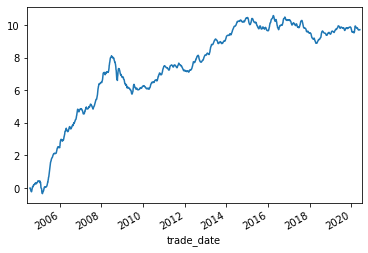

In [360]:
csmom.mean(1).cumsum().plot()

In [454]:
x = csmom.mean(1).dropna().values.flatten()
y = tsmom.mean(1).dropna().values.flatten()
X = sm.add_constant(x)
results = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':7})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6.008
Date:                Fri, 03 Jul 2020   Prob (F-statistic):             0.0143
Time:                        00:56:48   Log-Likelihood:                 5825.7
No. Observations:                3793   AIC:                        -1.165e+04
Df Residuals:                    3791   BIC:                        -1.164e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.003      3.352      0.0

In [82]:
x = ror_form.fillna(0).values.flatten()
y = ror_hold.fillna(0).values.flatten()

In [85]:
X = sm.add_constant(x)

In [477]:
results.params

array([0.00927816, 0.44063458])

In [478]:
results.tvalues

array([3.35215579, 2.45111002])

In [472]:
3.35215579 * 7.66081682e-06 / 3800

6.757960910340102e-09

In [458]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6.008
Date:                Fri, 03 Jul 2020   Prob (F-statistic):             0.0143
Time:                        14:08:22   Log-Likelihood:                 5825.7
No. Observations:                3793   AIC:                        -1.165e+04
Df Residuals:                    3791   BIC:                        -1.164e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.003      3.352      0.0

In [14]:
ror_form

,V,AL,A,CS,BU,C,CF,CU,P,RO,...,J,AG,ME,NI,AU,TC,Y,L,TA,M
trade_date,,,,,,,,,,,,,,,,,,,,,
2004-06-06,0.000000,-0.023579,0.019273,0.000000,0.000000,0.000000,-0.062257,-0.036154,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048913
2004-06-13,0.000000,-0.008418,-0.017299,0.000000,0.000000,0.000000,-0.006425,-0.030841,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012392
2004-06-20,0.000000,0.012755,0.023691,0.000000,0.000000,0.000000,-0.042410,0.015901,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014574
2004-06-27,0.000000,-0.000595,0.014757,0.000000,0.000000,0.000000,0.005674,0.025364,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031387
2004-07-04,0.000000,-0.015705,0.009583,0.000000,0.000000,0.000000,0.008281,0.003985,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-07,0.039579,-0.002497,-0.044880,-0.005373,0.030827,-0.002383,0.043388,0.029188,0.030450,0.020806,...,0.040495,0.006018,0.040553,0.036386,-0.010679,0.011896,0.006447,0.018157,0.027529,0.013558
2020-06-14,0.009643,0.028679,0.078616,0.006703,-0.042124,0.010141,-0.010789,0.034807,0.002038,0.024256,...,0.008198,-0.006305,-0.025231,-0.019716,0.008920,0.020274,-0.003676,0.009067,-0.007852,-0.003375
2020-06-21,-0.014932,0.016834,0.029215,0.010740,0.039657,0.012896,0.004763,0.019970,0.046682,0.029276,...,0.001354,-0.001938,0.020260,0.024583,-0.001722,0.002320,0.025657,0.016108,0.017532,-0.007291
